# Imports

In [1]:
import re
import pandas as pd
import json
import numpy as np
import seaborn as sns

# Extração de Dados

In [2]:
def df_tweets_candidatos(json_filename):
    df = pd.read_json(json_filename).drop(columns = ['replies'])
    return df


def df_tweets_respostas(json_filename):
    df = pd.read_json(json_filename).dropna().reset_index()[['replies']]
    ds = []
    for replies in df['replies'].to_list():
        for reply in replies:
            ds.append(reply)

    reply_df = pd.DataFrame (ds).drop(columns = ['attachments'])
    return reply_df

def df_tweets_cadidatos_respostas(json_filename):
    df_tweets_cand = df_tweets_candidatos(json_filename)
    df_tweets_reps = df_tweets_respostas(json_filename)

    return (df_tweets_cand, df_tweets_reps)

# Pré-Processamento

# Modelagem de Tópicos

# Similaridade de Textos

# Análise de Sentimentos

Aqui, temos a intenção de captar como as pessoas reagem aos tweets dos candidatos. Elas concordam, se opõem ou pouco se importam com tal posição sobre determinado tópico? Um meio de entendermos é através da análise de sentimentos. </br>
Para melhor organização, utilizaremos respostas dos tweets já classificados em tópicos.

## 1. Capta respostas aos tweets feitos pelos candidatos

In [3]:
replies_lula = df_tweets_respostas('datasets\lula-result.json')
replies_ciro = df_tweets_respostas('datasets\ciro-result.json')
# replies_bolsonaro = df_tweets_respostas('datasets\bolsonaro-result.json')

## 2. Relaciona candidato ao dataframe

In [4]:
replies_lula['candidato'] = 'lula'
replies_ciro['candidato'] = 'ciro'

## 3. Prepara bibliotecas e pacotes para análise de sentimentos

In [5]:
!pip install tensorflow

In [6]:
!pip install torch

In [7]:
!pip install transformers[sentencepiece]

## 4. O modelo de análise de sentimentos

Neste projeto, optamos por utilizar um modelo pré-treinado para tweets em português a partir do **Transformer**. O modelo em específico pode ser encontrado na plataforma **Hugging Face** pelo nome de `twitter-xlm-roberta-base-sentiment`.</br>
Seguindo sua documentação básica, basta inicializar o pipeline da forma abaixo.

In [8]:
from transformers import pipeline

In [12]:
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

## 5. Pré-processamento

Antes de começarmos a classificação de fato, optamos por excluir os nomes de usuários, substituir links por `http` e transformar todo o texto em caixa baixa durante o pré-processamento.

In [13]:
def pre_processamento(text):
    new_text = []
    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        t = '' if t.startswith('\n') else t
        new_text.append(t.lower())
    return " ".join(new_text)

### 5.1 Tratando corpus para melhor identificação

<p>Por se tratar de um contexto político muito específico, é necessário "traduzir" alguns tokens para sentimentos equivalentes. Assim, podemos ajudar de forma manual na classificação de cada resposta.</br>
<p>Para isso, cada candidato possui 2 dicionários, um de apoio e outro de oposição, responsáveis por substituir o token à esquerda pelo da direita. Importante dizer que os tokens foram retirados de amostras dos mesmos tweets.

#### Dicionários - Ciro Gomes

In [14]:
apoio_ciro = {
    "#prefirociro12":"concordo muito com ciro",
    "#ciro12":"concordo muito com ciro",
    "#cirocomandremarinho":"concordo muito com ciro",
    "#cirocomandrémarinho":"concordo muito com ciro",
    "#ciropresidente":"concordo muito com ciro",
    "#prefirociro":"concordo muito com ciro",
    "🌹":"concordo muito com o ciro",
    "1️⃣2️⃣":"ciro",
    "☝️✌️":"ciro",
    "✅":"eu apoio",
    "vou de ciro":"concordo muito com ciro",
    "vou cravar ciro":"concordo muito com ciro"
}

In [15]:
negacao_ciro = {    
    "🤮":"nojo ",
    "🤢":"nojo",
    "💩":"horrível",
    "1️⃣3️⃣":"lula ",
    "2️⃣2️⃣":"bolsonaro ",
    "#lulano1ºturno":"não gosto de você.",
    "#bolsonaroreeleito":"não gosto de você.",
    "#fechadocombolsonaro":"não gosto de você.",
    "#capitaodopovoquevaivencerdenovo":"não gosto nada de você.",
    "é bolsonaro!":"não gosto de você",
    "bolsonaro 22":"não gosto de você.",
    "lula eu apoio":"não gosto de você.",
    "bolsonaro eu apoio":"não gosto de você.",
    
    "vou de lula":"não concordo com ciro.",
    "vou cravar lula":"não concordo com ciro.",
    "vou de bolsonaro":"não concordo com ciro.",
    "vou cravar bolsonaro":"não concordo com ciro.",
    "vou de 13":"não concordo com ciro.",
    "vou cravar 13":"não concordo com ciro.",
    "vou de 22":"não concordo com ciro.",
    "vou cravar 22":"não concordo com ciro."
}

#### Dicionários - Lula

In [16]:
apoio_lula = {
    "lulano1ºturno":"concordo muito com lula",
    "1️⃣3️⃣":"lula ",
    "✅":"eu apoio",
    "#lulapresidente":"concordo muito com lula",
    "#prefirolula":"concordo muito com lula",
    "vou de lula":"concordo muito com lula",
    "vou cravar lula":"concordo muito com lula",
    "lula 13":"eu apoio muito lula"
}

In [17]:
negacao_lula = {
    "🌹":"não apoio você.",
    "🤮":"nojo ",
    "🤢":"nojo",
    "💩":"horrível",
    "1️⃣2️⃣":"ciro ",
    "2️⃣2️⃣":"bolsonaro ",
    "☝️✌️":"ciro",
    "#bolsonaroreeleito":"não gosto de você.",
    "#fechadocombolsonaro":"não gosto de você.",
    "#ocapitaovaivenceroladrao":"não gosto nada de você.",
    "#lulanuncamais":"não apoiaria você de forma alguma.",
    "#lulaladraoseulugarenaprisao":"odeio você.",
    "#capitaodopovoquevaivencerdenovo":"não gosto nada de você.",
    "#lularoubouobrasil":"lula roubou o brasil.",
    "é bolsonaro!":"não gosto de você",
    "bolsonaro 22":"não gosto de você.",
    "ciro eu apoio":"não gosto de você.",
    "bolsonaro eu apoio":"não gosto de você.",
    "fora pt":"não aceito você.",
    "lulaladrão":"ladrão",
    "l@dr@o":"ladrão",
    "l_a_d_r_ã_o":"ladrão",
    "lula nunca mais":"jamais aceitarei lula",
    "pt nunca mais":"jamais aceitarei o pt novamente",
    "ptralha":"ruim",
    
    "vou de ciro":"não concordo com lula.",
    "vou cravar ciro":"não concordo com lula.",
    "vou de bolsonaro":"não concordo com lula.",
    "vou cravar bolsonaro":"não concordo com lula.",
    "vou de 12":"não concordo com lula.",
    "vou cravar 12":"não concordo com lula.",
    "vou de 22":"não concordo com lula.",
    "vou cravar 22":"não concordo com lula."
}

Substitui tokens não classificáveis devido ao contexto por outros mais apropriados.

In [18]:
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

## 6. Analisando sentimentos 

Retorna uma lista de dicionários já contendo a classificação de sentimentos.  
**Parâmetros de entrada**:
>**df_candidato**: dataframe pandas das respostas aos tweets de um determinado candidato,  
>**dic_apoio**: dicionário de tokens de apoio,  
>**dic_oposicao**: dicionário de tokens de oposição

**Retorno**: 
>**author_id**: id do autor do tweet pai,  
>**conversation_id**: id da thread,  
>**created_at**: datetime de criação do tweet,  
>**candidato**: nome do candidato a presidente,  
>**topico**: tópico a que o tweet pai pertence (proveniente da ``Modelagem de Tópicos``),  
>**id**: id do tweet de resposta,  
>**texto_original**: texto original do tweet de resposta,  
>**texto_tratado**: text tratado do tweet de resposta,  
>**sentimento**: sentimento classificado em positivo, negativo ou neutro,  
>**sentimento_score**: score entre 0 e 1 do sentimento classificado  

In [19]:
def analisa_sentimentos(df_candidato, dic_apoio, dic_oposicao):
    candidato_sentimentos = []
    
    for linha in df_candidato.iterrows():
        l = list(linha)

        tratamento = pre_processamento(l[1]['text'])
        apoio = replace_all(tratamento, dic_apoio)
        text = replace_all(apoio, dic_oposicao)
        sentimento = sentiment_task(text)

        dic = {"author_id": l[1]['author_id'],
               "conversation_id": l[1]['conversation_id'],
               "created_at": l[1]['created_at'],
               "candidato": l[1]['candidato'],
               "id": l[1]['id'],
               "texto_original": l[1]['text'],           
               "texto_tratado": text,
               "sentimento": sentimento[0]['label'],
               "sentimento_score": np.round(float(sentimento[0]['score']), 3)
              }

        candidato_sentimentos.append(dic)
        
    return candidato_sentimentos

Calcula taxas de aprovação e rejeição de determinado candidato.

In [20]:
def calcula_taxas(df_sentimentos):
    gb = df_sentimentos[['texto_tratado','sentimento']].groupby(['sentimento']).count().reset_index()
    aprovacao = float(gb[gb['sentimento'] == 'Positive']['texto_tratado']/int(gb.sum()['texto_tratado']))
    rejeicao = float(gb[gb['sentimento'] == 'Negative']['texto_tratado']/int(gb.sum()['texto_tratado']))

    print(f"Taxa de aprovação do candidato: {np.round(aprovacao*100,1)}%")
    print(f"Taxa de rejeição do candidato: {np.round(rejeicao*100,1)}%")

### 6.1 Lula

In [21]:
lula_sentimentos = analisa_sentimentos(replies_lula, apoio_lula, negacao_lula)
lula_model = pd.DataFrame.from_records(lula_sentimentos)
# retira respostas feitas apenas com links
lula_model = lula_model[lula_model.texto_tratado != ' http'].reset_index().drop(columns='index')
lula_model.head()

,author_id,conversation_id,created_at,candidato,id,texto_original,texto_tratado,sentimento,sentimento_score
0,1555314824648822786,1560319888643719169,2022-08-19T01:28:21.000Z,lula,1560438485970042881,@LeonardoDeodoro @LulaOficial Cai em onda de P...,cai em onda de pt não,Negative,0.705
1,1555314824648822786,1560319888643719169,2022-08-19T01:27:39.000Z,lula,1560438309318545410,@LulaOficial Cala boca bandido https://t.co/4n...,cala boca bandido http,Negative,0.850
2,1109601156316254208,1560319888643719169,2022-08-19T01:26:29.000Z,lula,1560438018372210689,@LulaOficial Tá certo. Pensa que o povo é otário.,tá certo. pensa que o povo é otário.,Negative,0.858
3,1334214409170849796,1560319888643719169,2022-08-19T01:23:58.000Z,lula,1560437383216173056,@Laura_livia123 @XRZTIMO @LulaOficial kkkkkkkk...,kkkkkkkkkkkkkkkkkkkkkkkk,Neutral,0.519
4,1518923220942004229,1560319888643719169,2022-08-19T01:23:57.000Z,lula,1560437378858340353,@LeonardoDeodoro @LulaOficial Manteve diálogos...,"manteve diálogos ""cabulosos"" com traficantes...",Negative,0.609


### 6.1.1 Visualização da análise de sentimentos para Lula

<AxesSubplot:xlabel='sentimento', ylabel='count'>

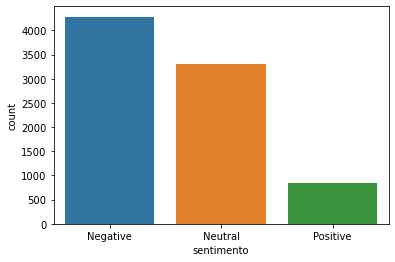

In [22]:
sns.countplot(x = lula_model['sentimento'])

### 6.1.2 Taxas de aprovação e rejeição: Lula

In [23]:
calcula_taxas(lula_model)

Taxa de aprovação do candidato: 10.0%
Taxa de rejeição do candidato: 50.9%


### 6.2 Ciro Gomes

In [24]:
ciro_sentimentos = analisa_sentimentos(replies_ciro, apoio_ciro, negacao_ciro)
ciro_model = pd.DataFrame.from_records(ciro_sentimentos)
# retira respostas feitas apenas com links
ciro_model = ciro_model[ciro_model.texto_tratado != ' http'].reset_index().drop(columns='index')
ciro_model.head()

,author_id,conversation_id,created_at,candidato,id,texto_original,texto_tratado,sentimento,sentimento_score
0,2557532220,1560439246913257475,2022-08-19T01:46:41.000Z,ciro,1560443100576862209,@Juninho_Ebersol @cirogomes @AndreMarinho E aí...,"e aí ele vai lá e debate, conversa, se expõ...",Negative,0.454
1,163749471,1560439246913257475,2022-08-19T01:46:12.000Z,ciro,1560442980359618560,"@cirogomes @AndreMarinho Que fase, hein...","que fase, hein...",Negative,0.836
2,1057378799321522178,1560439246913257475,2022-08-19T01:45:43.000Z,ciro,1560442856673869824,@cirogomes @AndreMarinho Alckmin e Lula. Versã...,"alckmin e lula. versão ""ninguém liga""",Neutral,0.548
3,47700524,1560439246913257475,2022-08-19T01:43:10.000Z,ciro,1560442214395830273,@cirogomes @AndreMarinho Foi muito bom. Não pr...,foi muito bom. não precisava nem ter partici...,Positive,0.836
4,73403327,1560439246913257475,2022-08-19T01:42:47.000Z,ciro,1560442120258953219,@cirogomes @AndreMarinho #CiroPresidente12,concordo muito com ciro12,Positive,0.540


### 6.2.1 Visualização da análise de sentimentos para Ciro

<AxesSubplot:xlabel='sentimento', ylabel='count'>

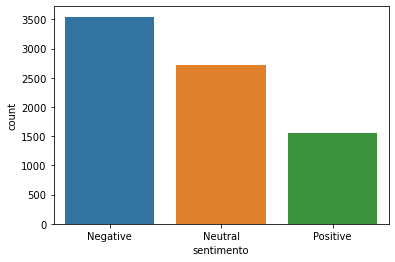

In [25]:
sns.countplot(x = ciro_model['sentimento'])

### 6.2.2 Taxas de aprovação e rejeição: Ciro Gomes

In [26]:
calcula_taxas(ciro_model)

Taxa de aprovação do candidato: 19.8%
Taxa de rejeição do candidato: 45.4%


## 7. Conclusão da Análise de Sentimentos

<p>A interpretação de texto não é uma tarefa trivial para humanos, assim como não é para algoritmos de PLN. Sendo assim, não é uma tarefa simples classificar tweets em positivos ou negativos, pois estamos lidando com vícios de linguagem, sarcasmo, ironias, diferentes interpretações e, neste caso, um contexto socio-político muito forte da situação brasileira da última década.
<p>Considerando os resultados que extraímos, é possível notar a forte rejeição a todos os candidatos que apresentamos. Reflexo dos acontecimentos dos últimos anos que corroboram com a imagem de desconfiança para com políticos. 
<p>Dentro os 3 presidenciáveis, <b>Ciro possui a maior taxa de aprovação</b> e a <b>menor taxa de rejeição</b>, mas isso não necessariamente reflete os resultados das eleições, pois Ciro possui o menor número de eleitores entre os três candidatos. Apenas enfatiza que dentro desta bolha social (Twitter), os usuários que interagem com seus posts o fazem mais positivamente do que os usuários dos demais políticos.

## 8. Possíveis melhorias na Análise de Sentimentos
### Tratamento para falsos positivos
<p>Ao responder o tweet de um candidato, é comum que os eleitores afirmem apoio a outro presidenciável. Nesses casos, a classificação de sentimento daquela resposta em si pode ser positiva para o candidato que ele apoia, mas negativa para o dono do tweet.
<p>Sendo assim, optamos por inverter o sentimento. O tratamento fica nítido no caso abaixo, em que o usuário responde ao Ciro Gomes:

In [27]:
sentiment_task("Lula vai trazer amor e paz e todos vão amanhecer felizes por voltarem a sonhar")

[{'label': 'Positive', 'score': 0.8678022027015686}]

É claramente um sentimento positivo, mas direcionado ao Lula. Como se trata de outro candidato, a classificação se tornaria negativa através de um possível tratamento.